In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling,
                          langevin_dynamics,
                          mala_sampling,
                          mala_dynamics,
                          xtry_langevin_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          DotDict)
from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from metrics import Evolution, plot_chain_metrics

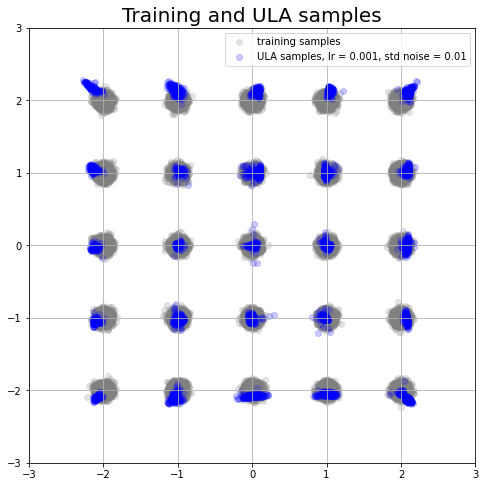

In [13]:
X_langevin = torch.FloatTensor(z_last_np).to(proposal.device)
X_langevin = G(X_langevin).data.cpu().numpy()
mode = 'ULA'
params = f'lr = {grad_step}, std noise = {round(eps_scale, 3)}'
plot_fake_data_mode(X_langevin, X_train, mode, 
                    scaler = scaler,
                    params = params)

100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


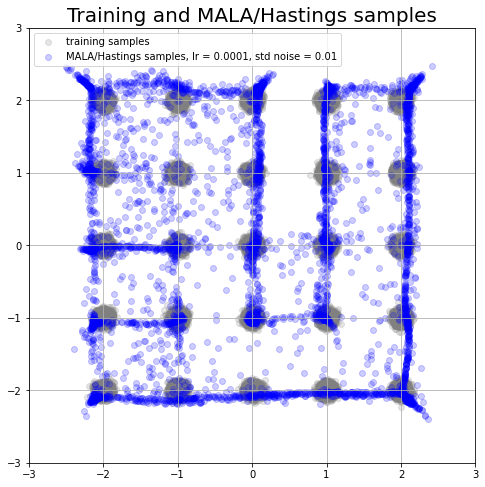

In [140]:
batch_size_sample = 5000
n_steps = 10
grad_step = 1e-4
eps_scale = 1e-2
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = 1,
                      acceptance_rule = 'Hastings',
                      latent_transform = G)

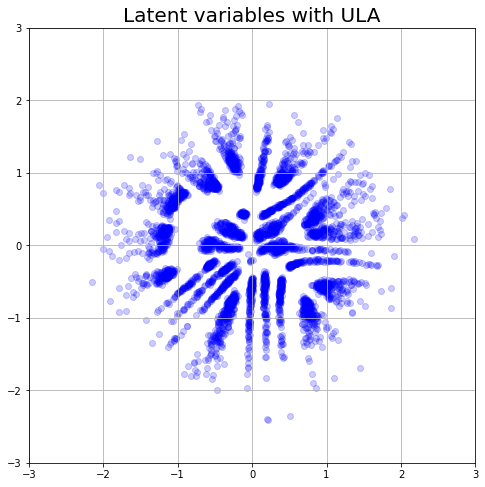

In [16]:
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(z_last_np[:,:1], z_last_np[:,1:], alpha=0.2, color='blue', 
            marker='o', label = 'latent variables')
plt.grid(True)
plt.show()

In [ ]:
def ais_dynamics(z, target, proposal, n_steps, grad_step, eps_scale, N, betas, rhos):
    z_sp = [z[:, -1, :].clone().detach()]
    batch_size, T, z_dim = z.shape[0], z.shape[1], z.shape[2]
    T = T - 1  #??
    # T = len(betas) - 2
    device = z.device

    mh_transition = MH_Transition(z_dim, device)
    acceptence = torch.zeros(batch_size).to(device)

    betas = np.array(betas)
    betas_diff = torch.FloatTensor(betas[:-1] - betas[1:]).to(device) #n-1

    def compute_probs_from_log_probs(log_probs):
        mask_zeros = log_probs > 0.
        log_probs[mask_zeros] = 0.
        probs = log_probs.exp()
        return probs

    z_flat = torch.transpose(z, 0, 1).reshape((batch_size*z.shape[1], z_dim)).detach().clone()
    z_flat.requires_grad_(True)
    E_flat, grad_flat = grad_energy(z_flat, target, None)
    grad = torch.transpose(grad_flat.reshape(list(z.shape[:-1][::-1]) + [z.shape[-1]]), 0, 1).detach().clone()
    E = E_flat.reshape(z.shape[:-1][::-1]).T.data

    for _ in trange(n_steps):
        v = torch.zeros((batch_size, T + 1, N, z_dim), dtype = z.dtype).to(device)
        u = torch.zeros((batch_size, T + 1, N), dtype = z.dtype).to(device)

        #step 1
        kappa = torch.zeros((batch_size, T + 1, z_dim), dtype = z.dtype).to(device)
        kappa_t_noise = proposal.sample([batch_size, T + 1])
        kappa[:, 0, :] = rhos[-1]*z[:, 0, :] + ((1 - rhos[-1]**2)**0.5) * kappa_t_noise[:, 0, :]
        
        for t in range(1, T + 1):
            beta = betas[::-1][t]
            rho = rhos[::-1][t]

            not_equal_mask = torch.ne(z[:, t, :], z[:, t - 1, :]).max(dim=-1)[0]
            equal_mask = ~not_equal_mask             
            num_not_equal = not_equal_mask.sum()
            num_equal = equal_mask.sum()
            
            if num_not_equal > 0:
                z_t_not_equal = z[not_equal_mask, t, :].detach().clone()
                z_t_1_not_equal = z[not_equal_mask, t - 1, :].detach().clone()
                z_t_not_equal.requires_grad_(True)
                z_t_1_not_equal.requires_grad_(True)

                #E_t_1_not_equal, grad_t_1_not_equal = grad_energy(z_t_1_not_equal, target, x=None)
                E_t_1_not_equal = E[not_equal_mask, t - 1]
                grad_t_1_not_equal = grad[not_equal_mask, t - 1, :]
                
                log_probs, _, _ = mh_transition.compute_log_probs(z_t_1_not_equal, 
                                                z_t_not_equal, 
                                                E_t_1_not_equal, 
                                                grad_t_1_not_equal, 
                                                grad_step, eps_scale, target, beta=beta)
                

                # v[not_equal_mask, t, 0, :] = (z_t_not_equal - (1. - grad_step)*z_t_1_not_equal \
                #                                             + grad_step*betas[t]*grad_point1)/eps_scale
                v[not_equal_mask, t, 0, :] = (z_t_not_equal - z_t_1_not_equal + grad_step * beta * grad_t_1_not_equal)/eps_scale

                probs = compute_probs_from_log_probs(log_probs)
                generate_uniform_var = mh_transition.uniform.sample([probs.shape[0]]).to(probs.device)
                weight_uniform_var = generate_uniform_var * probs

                u[not_equal_mask, t, 0] = weight_uniform_var.float()
            
            if num_equal > 0:
                z_t_equal = z[equal_mask, t, :]
                z_t_1_equal = z[equal_mask, t - 1, :].detach().clone()
                z_t_1_equal.requires_grad_(True)
                
                #E_t_1_equal, grad_t_1_equal = grad_energy(z_t_1_equal, target, x=None)
                E_t_1_equal = E[equal_mask, t - 1].detach().clone()
                grad_t_1_equal = grad[equal_mask, t - 1, :].detach().clone()
                
                #second_part_no_noise = (1. - grad_step)*z_t_1_equal - grad_step*betas[t]*grad_t_1_equal
                second_part_no_noise = z_t_1_equal - grad_step * beta * grad_t_1_equal

                stop = False
                num_updates = 0
                update_mask = torch.zeros(num_equal, dtype = torch.bool).to(z_t_equal.device)
                z_t_1_equal = z_t_1_equal.detach().clone()
                z_t_1_equal.requires_grad_(True)

                while not stop:
                    cur_u = mh_transition.uniform.sample([num_equal]).to(z_t_equal.device)
                    cur_v = proposal.sample([num_equal]).to(z_t_equal.device)
                    second_part = second_part_no_noise + cur_v*eps_scale
                    second_part = second_part.detach().clone()
                    second_part.requires_grad_(True)
                    
                    log_probs, _, _ = mh_transition.compute_log_probs(z_t_1_equal, 
                                                    second_part, 
                                                    E_t_1_equal, 
                                                    grad_t_1_equal, 
                                                    grad_step, eps_scale, target, beta=beta)

                    probs = compute_probs_from_log_probs(log_probs)
                    mask_assign = (cur_u <= probs)
                    new_assign = torch.logical_and(mask_assign, ~update_mask) 
                    
                    u[equal_mask, t, 0][new_assign] = cur_u[new_assign]
                    v[equal_mask, t, 0, :][new_assign] = cur_v[new_assign]
                    
                    update_mask = torch.logical_or(update_mask, new_assign)
                    updates_num = update_mask.sum()
                    if updates_num == num_equal:
                        stop = True
            
            kappa[:, t, :] = rho*v[:, t, 0, :] + ((1 - rho**2)**0.5) * kappa_t_noise[:, t, :]

        #step 2
        W = proposal.sample([batch_size, N - 1])
        #Z - tensor (bs, T + 1, N, dim)
        Z = torch.zeros((batch_size, T + 1, N, z_dim), dtype = z.dtype).to(device)
        
        kappa_repeat = kappa[:, 0, :].unsqueeze(1).repeat(1, N - 1, 1)
        kappa_N_noise = proposal.sample([batch_size, N - 1])
        kappa_repeat_N = kappa.unsqueeze(2).repeat(1, 1, N - 1, 1)

        Z[:, :, 0, :] = z
        Z[:, 0, 1:, :] = rhos[-1]*kappa_repeat + ((1 - rhos[-1]**2)**0.5) * kappa_N_noise

        kappa_flat = torch.transpose(Z[:, 0, 1:, :], 0, 1).reshape((batch_size*(N-1), z_dim)).detach().clone()
        kappa_E_flat, kappa_grad_flat = grad_energy(kappa_flat, target)
        kappa_E = kappa_E_flat.reshape(N-1, batch_size).T
        kappa_grad = torch.transpose(kappa_grad_flat.reshape(N-1, batch_size, z_dim), 0, 1)
        
        energy = torch.zeros(batch_size, T+1, N).to(device)
        
        #z_flat = torch.transpose(z, 0, 1).reshape((batch_size*(T+1), z_dim)).detach().clone()
        #E_flat, grad_flat = grad_energy(z_flat, target, None)
        #E_ = E_flat.reshape(T+1, batch_size).T
        #grad_ = torch.transpose(grad_flat.reshape(T+1, batch_size, z_dim), 0, 1)
        
        energy[:, :, 0] = E.data
        energy[:, 0, 1:] = kappa_E

        grads = torch.zeros(batch_size, T+1, N, z_dim).to(device)
        grads[:, :, 0, :] = grad.detach().clone()
        grads[:, 0, 1:, :] = kappa_grad
        
        W_2 = proposal.sample([batch_size, T, N - 1])
        
        for t in range(1, T + 1):
            beta = betas[::-1][t]
            rho = rhos[::-1][t]

            v[:, t, 1:, :] = rho*kappa_repeat_N[:, t - 1, :, :] + ((1 - rho**2)**0.5) * W_2[:, t - 1, :, :]
            z_t_1_j_shape = Z[:, t - 1, 1:, :].shape
            z_t_1_j_flatten = torch.transpose(Z[:, t - 1, 1:, :], 0, 1).reshape((batch_size*(N-1), z_dim)).detach().clone().to(device)
            z_t_1_j_flatten.requires_grad_(True)
            
            #_, grad_z_t_1_j_flatten = grad_energy(z_t_1_j_flatten, target, x=None)
            #grad_z_t_1_j = torch.transpose(grad_z_t_1_j_flatten.reshape(list(z_t_1_j_shape[:-1][::-1]) + [z_t_1_j_shape[-1]]), 0, 1)
            grad_z_t_1_j = grads[:, t - 1, 1:, :]
            grad_z_t_1_j_flatten = torch.transpose(grad_z_t_1_j, 0, 1).reshape((batch_size*(N - 1), z_dim)).detach().clone().to(device)
            E_z_t_1_j = energy[:, t - 1, 1:]
            E_z_t_1_j_flatten = E_z_t_1_j.T.reshape(batch_size*(N - 1))

            Z_t_1_j = Z[:, t - 1, 1:, :]
            Z_t_1_j_shape = Z_t_1_j.shape
            # p_t_j = (1. - grad_step)*Z_t_1_j - grad_step*betas[t]*grad_z_t_1_j \
            #                                         + eps_scale*v[:, t, 1:, :]
            p_t_j = Z_t_1_j - grad_step*beta*grad_z_t_1_j  + eps_scale*v[:, t, 1:, :]
            
            p_t_j_flatten = torch.transpose(p_t_j, 0, 1).reshape((batch_size*(N-1), z_dim)).detach().clone().to(device)
            p_t_j_flatten.requires_grad_(True)
            
            Z_t_1_j_flatten = torch.transpose(Z_t_1_j, 0, 1).reshape((batch_size*(N-1), z_dim)).detach().clone().to(device)
            Z_t_1_j_flatten.requires_grad_(True)
            
            #print(Z_t_1_j_flatten.device)
            #print(p_t_j_flatten.device)
            #print(E_z_t_1_j_flatten.device)
            #print(grad_z_t_1_j_flatten.device)
            z_t, E_t, grad_t = mh_transition.do_transition_step(Z_t_1_j_flatten, 
                                            p_t_j_flatten, 
                                            E_z_t_1_j_flatten, 
                                            grad_z_t_1_j_flatten, 
                                            grad_step, eps_scale, target, beta)

            z_t = torch.transpose(z_t.reshape(N - 1, batch_size, z_dim), 0, 1)
            E_t = E_t.reshape(N - 1, batch_size).T
            grad_t = torch.transpose(grad_t.reshape(N - 1, batch_size, z_dim), 0, 1)
            Z[:, t, 1:, :] = z_t
            energy[:, t, 1:] = E_t.detach().clone()
            grads[:, t, 1:, :] = grad_t.detach().clone()
            
        log_weights = -(betas_diff[None, :, None] * energy[:, 1:, :]).sum(1)
            
        max_logs = torch.max(log_weights, dim = 1)[0]
        log_weights = log_weights - max_logs[:, None]
        weights = torch.exp(log_weights)
        sum_weights = torch.sum(weights, dim = 1)
        weights = weights/sum_weights[:, None]
        weights[weights != weights] = 0.
        weights[weights.sum(1) == 0.] = 1.
        
        indices = torch.multinomial(weights, 1).squeeze().tolist()
        z = Z[np.arange(batch_size), :, indices, :]
        E = energy[np.arange(batch_size), :, indices]
        grad = grads[np.arange(batch_size), :, indices, :]
        z_sp.append(z[:, -1, :].detach().clone())

    return z_sp